# VAE datos sinteticos para datos de salud mental

# 1 Introducción y objetivos

El presente trabajo tiene como **objetivo principal** la **síntesis de datos clínicos** mediante la implementación de un modelo de **Autoencoder Variacional (VAE)**, aplicado a un conjunto de datos relacionados con la salud mental. La generación de datos sintéticos representa una línea de investigación emergente en el ámbito sanitario, especialmente relevante dada la dificultad de acceso a datos reales por razones éticas, legales y de privacidad.

Además de la generación de datos sintéticos, este estudio persigue los siguientes **objetivos secundarios**:

1. **Explorar y analizar el conjunto de datos original**, identificando características estructurales y posibles problemas de calidad como valores nulos, redundancias o atípicos.
2. **Evaluar la calidad de los datos generados**, mediante análisis estadísticos y visuales que comparen las distribuciones originales y sintéticas.
3. **Comprobar la utilidad de los datos sintéticos** en tareas de aprendizaje automático, evaluando si modelos entrenados sobre datos generados pueden alcanzar rendimientos comparables a los entrenados sobre datos reales.

A través de estos pasos se pretende no solo demostrar la capacidad generativa del modelo, sino también su **viabilidad para enriquecer procesos de análisis y modelado en contextos clínicos reales**, preservando al mismo tiempo la privacidad de los pacientes.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport #!pip install ydata_profiling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras import layers, models, backend as K, losses, Model
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [4]:
#!pip install ydata_profiling


### ¿Qué es un Autoencoder Variacional (VAE)?

Un **Autoencoder Variacional (VAE)** es un modelo generativo basado en redes neuronales, diseñado para aprender una representación **latente** (comprimida y estructurada) de los datos de entrada, a partir de la cual se puedan reconstruir datos similares.

A diferencia de un autoencoder tradicional (AE), que aprende una codificación determinista, el VAE incorpora una perspectiva **probabilística**, modelando la distribución de los datos mediante variables aleatorias. Esta formulación le permite **generar nuevos datos** realistas al muestrear del espacio latente.

#### Arquitectura general del VAE

Un VAE consta de tres componentes principales:

1. **Encoder**: Toma una entrada $x$ y estima los parámetros (media $\mu$ y desviación estándar $\sigma$) de una distribución gaussiana que representa su codificación latente $z$.

   $$ q(z|x) = \mathcal{N}(z; \mu(x), \sigma^2(x)) $$

2. **Reparametrización**: Para permitir el entrenamiento por retropropagación, se aplica el truco de la reparametrización:

   $$ z = \mu + \sigma \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I) $$

3. **Decoder**: Reconstruye una versión aproximada $\hat{x}$ de la entrada a partir del vector latente $z$:

   $$ p(x|z) $$

---

#### Función de pérdida: reconstrucción + regularización

La función de coste de un VAE combina dos términos:

1. **Error de reconstrucción**: mide la diferencia entre la entrada original $x$ y la reconstrucción $\hat{x}$ (usualmente mediante cross-entropy o MSE).
2. **Divergencia KL**: penaliza las desviaciones entre la distribución latente aprendida $q(z|x)$ y una distribución prior estándar (usualmente $\mathcal{N}(0, I)$), fomentando un espacio latente continuo y estructurado.

La pérdida total se expresa como:

$$
\mathcal{L}(x) = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{KL}(q(z|x) || p(z))
$$

---

#### Aplicaciones del VAE

- **Generación de datos sintéticos**
- **Reducción de dimensionalidad**
- **Detección de anomalías**
- **Aprendizaje no supervisado**
- **Representación semántica en el espacio latente**

En el contexto sanitario, los VAE permiten generar datos simulados realistas que conservan las propiedades estadísticas de los datos reales, facilitando la investigación respetando la privacidad del paciente.


# 1. Preprocesamiento


In [5]:
df = pd.read_csv('Mental Health Dataset.csv')

### Análisis Exploratorio Automático (EDA)

Para comprender mejor la estructura del conjunto de datos original, se ha utilizado la herramienta `ydata-profiling` (antes conocida como `pandas-profiling`), que permite generar automáticamente un informe detallado del dataset.

Este informe incluye:
- El número de registros y variables
- Tipos de datos por columna
- Distribuciones estadísticas univariantes
- Detección de valores ausentes y valores extremos (outliers)
- Matriz de correlación y multicolinealidad

Este análisis exploratorio automatizado facilita la identificación de problemas de calidad y guías para el posterior preprocesamiento.

A continuación se muestra el informe interactivo generado.


In [22]:
profile = ProfileReport(df, title="Informe EDA Salud Mental")


In [23]:
profile.to_file("informe_eda_salud_mental.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 56.13it/s]
C:\Users\Mariapra\AppData\Roaming\Python\Python311\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 9 9 9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
C:\Users\Mariapra\AppData\Roaming\Python\Python311\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2 2 2 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
C:\Users\Mariapra\AppData\Roaming\Python\Python311\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an ite

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
profile.to_notebook_iframe()


### Resultados del Análisis Exploratorio (EDA)

El análisis exploratorio realizado con `ydata-profiling` ha generado un informe completo del dataset original, disponible en:  
`informe_eda_salud_mental.html`  
(*Versión local: file:///C:/Users/Mariapra/OneDrive/Mineria/Trabajo/informe_eda_salud_mental.html*)

A continuación se resumen los principales hallazgos:

#### Estructura general del dataset
- El conjunto contiene múltiples variables categóricas relacionadas con historia clínica, estrés, hábitos y contexto social/laboral.
- No hay variables numéricas continuas estándar, por lo que será necesario codificar adecuadamente las variables categóricas para su uso en modelos generativos como VAE.

#### Calidad de los datos
- Se detectan valores ausentes, principalmente en `self_employed` y posiblemente en `mental_health_interview`.
- Existen registros duplicados exactos, lo cual puede introducir sesgo y deberá corregirse en el preprocesamiento.
- La matriz de nullidad muestra un patrón estructurado en las ausencias, no completamente aleatorio, lo que sugiere necesidad de análisis cuidadoso o imputación condicional.

#### Distribución de variables
- Alta predominancia de ciertos valores en variables clave:
  - Mayoría de participantes mujeres.
  - Gran parte con ocupación “Corporate”.
  - País dominante: `United States`.
- Se observan desequilibrios notables en la variable `treatment`, lo que puede afectar el rendimiento de modelos discriminativos si no se ajusta adecuadamente.

#### Correlaciones entre variables

La matriz de correlación muestra relaciones interesantes:
- `family_history` se correlaciona positivamente con `treatment`, indicando coherencia entre antecedentes familiares y tratamiento actual.
- Otras asociaciones relevantes son:
  - `mental_health_interview` con `care_options`
  - `Mood_Swings` con `Mental_Health_History`
- No se observan colinealidades extremas (>|0.7|), por lo que no es necesario eliminar atributos, pero sí conviene agruparlos lógicamente en el modelado.

#### Conclusión

Este análisis exploratorio confirma la utilidad de realizar un preprocesamiento cuidadoso: limpieza de duplicados, tratamiento de valores nulos, codificación de variables categóricas y normalización. Además, valida el uso de un modelo generativo como el **Autoencoder Variacional (VAE)**, capaz de captar las complejas relaciones latentes entre las variables analizadas.


### Preprocesamiento de los datos

En esta etapa se realiza una limpieza básica del conjunto de datos para garantizar que el modelo VAE reciba entradas consistentes y estructuradas. Las principales acciones son:

1. **Eliminación de la columna `Timestamp`**, por no aportar información relevante para el análisis.
2. **Conversión de la variable `Country` en una columna binaria `Es_USA`**, que indica si la persona reside en Estados Unidos (`1`) o no (`0`).
3. **Eliminación de duplicados** para asegurar que no haya entradas repetidas que puedan sesgar el entrenamiento.
4. **Codificación de las variables categóricas** mediante `LabelEncoder`, permitiendo convertir texto en valores numéricos utilizables por el modelo.
5. **Normalización de los datos** usando `StandardScaler`, para centrar las variables y facilitar el entrenamiento del VAE.
6. **Eliminación de filas con valores nulos (`dropna()`)**.

> **Nota aclaratoria:**  
> Aunque existen técnicas más sofisticadas como la imputación para tratar los valores nulos, en este caso se ha optado por eliminarlos directamente con `dropna()`. Esta decisión se justifica porque el conjunto de datos original es lo suficientemente amplio como para tolerar una reducción sin perder representatividad. Además, esta estrategia simplifica el flujo de trabajo y evita introducir posibles sesgos derivados de la imputación artificial.




In [7]:
# eliminar la columna Timestap que no aporta valor al analisis
df.drop('Timestamp', axis=1, inplace=True)

In [8]:
#eliminar duplicados
df.drop_duplicates(inplace=True)

In [9]:
#eliminar filas con datos faltantes
df.dropna(inplace=True)

In [10]:
# Columna Country -> Es_USA
df['Es_USA'] = (df['Country'] == 'United States').astype(int)
df.drop('Country', axis=1, inplace=True)

In [11]:
# Codificar variables categóricas
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

In [12]:
# Guardar copia original para comparar luego
original_data = df.copy()

In [13]:
# Escalar
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# 2 Construcción y entrenamiento del modelo VAE

## Funcionamiento del Autoencoder Variacional (VAE)

El VAE es un modelo generativo que permite aprender una representación latente probabilística de los datos. En nuestro caso, se ha utilizado para generar datos sintéticos de salud mental. A continuación se detalla cada componente:

---

### 1. **Datos de entrada (`X_scaled`)**

Los datos reales del paciente, tras el preprocesamiento (eliminación de nulos, codificación numérica y estandarización), entran al modelo como vectores.

Ejemplo:
> Género = Mujer, Estrés = Alto, Tratamiento = Sí → Convertido a valores numéricos estandarizados.

---

### 2. **Encoder**

El encoder transforma estos datos en una **distribución latente**:
- `z_mean`: la media (centro de la distribución).
- `z_log_var`: el logaritmo de la varianza (define la dispersión de la nube de puntos en el espacio latente).

Esto representa cada ejemplo no como un punto único, sino como una **nube de probabilidad** en un espacio latente multidimensional.

---

### 3. **Sampling (Reparametrización)**

**Este es el paso clave que diferencia al VAE de un autoencoder clásico.**

El objetivo es generar un punto `z` aleatorio dentro de la nube (definida por `z_mean` y `z_log_var`), usando la siguiente fórmula:

  \[
z = \mu + \sigma \cdot \epsilon \quad \text{donde } \epsilon \sim \mathcal{N}(0, I)
\] 

Esto se conoce como **truco de reparametrización**, y permite que el modelo sea entrenable mediante backpropagation.

Cada observación se representa como una distribución, y **el sampling selecciona un punto aleatorio de esa distribución** para reconstruirla.

<img src="vae_sampling.jpg" alt="Sampling VAE" width="300">

---

### 4. **Decoder**

El punto `z` generado en el sampling se pasa al decoder, que intenta reconstruir los datos originales. Esta salida será una **versión sintética y plausible**, no una copia exacta del dato original.

---

### 5. **Reconstrucción y funciones de pérdida**

El VAE optimiza dos componentes de la pérdida:

- **Pérdida de reconstrucción**: qué tan diferente es la salida respecto al input original (se mide con MSE o cross-entropy).
- **Divergencia KL**: penaliza si las distribuciones latentes se alejan demasiado de una distribución normal estándar, manteniendo regularidad y continuidad en el espacio latente.

---

### 6. **Pérdida total**

La suma de la reconstrucción y la divergencia KL constituye la **pérdida total**. El objetivo del entrenamiento es minimizarla.

---

### 7. **Generación de nuevos datos sintéticos**

Una vez entrenado el modelo:

1. Se selecciona un `z` aleatorio en el espacio latente.
2. Se pasa al decoder.
3. Se obtiene un paciente sintético, **estadísticamente similar pero no idéntico** a los reales.

Esto permite crear poblaciones artificiales realistas para su uso en investigación, entrenamientos o modelos de predicción.

---

### Esquema general del proceso

<img src="vae_diagrama.jpg" alt="Diagrama VAE" width="400">

---

### ¿Por qué es importante el sampling?

Sin este mecanismo, el modelo sería determinista (autoencoder clásico). Gracias al sampling:
- Se pueden generar infinitas muestras nuevas.
- El modelo es más **robusto y generaliza mejor**.
- Se puede interpolar entre puntos latentes para explorar variaciones sutiles de los datos.

---


In [42]:
# 3. DEFINICIÓN DEL VAE MODERNO
original_dim = scaled_data.shape[1]
intermediate_dim = 32
latent_dim = 16

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            ))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {"loss": self.total_loss_tracker.result()}

# Encoder
encoder_inputs = layers.Input(shape=(original_dim,))
x = layers.Dense(intermediate_dim, activation="relu")(encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
outputs = layers.Dense(original_dim)(x)
decoder = Model(latent_inputs, outputs, name="decoder")

# Compilar y entrenar
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(scaled_data, epochs=30, batch_size=32)

Epoch 1/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 16.9934
Epoch 2/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 13.8134
Epoch 3/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 13.4130
Epoch 4/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 13.2763
Epoch 5/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 13.1813
Epoch 6/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 13.0869
Epoch 7/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 13.0395
Epoch 8/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 12.9968
Epoch 9/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 12.9302
Epoch 10/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 12.8842
Epoch 11/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 12.8074
Epoch 12/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 12.8032
Epoch 13/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 12.7738
Epoch 14/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 12.7598
Epoch 15/30
290

Epoch 1/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 12.7011
Epoch 2/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 12.7206
Epoch 3/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 12.6828
Epoch 4/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 12.6983
Epoch 5/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 12.6729
Epoch 6/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 12.6893
Epoch 7/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 12.6781
Epoch 8/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 12.6850
Epoch 9/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 12.6823
Epoch 10/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 12.6712
Epoch 11/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 12.6705
Epoch 12/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 12.6979
Epoch 13/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 12.6844
Epoch 14/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 12.6750
Epoch 15/30
290

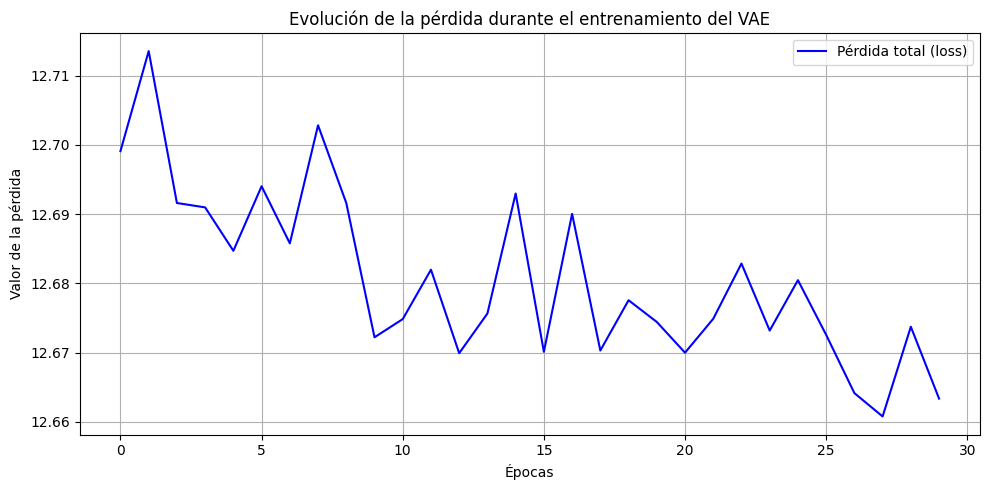

In [45]:
# Visualización de la evolución de la pérdida durante el entrenamiento
history = vae.fit(scaled_data, epochs=30, batch_size=32)

losses = history.history['loss']

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Pérdida total (loss)', color='blue')
plt.title('Evolución de la pérdida durante el entrenamiento del VAE')
plt.xlabel('Épocas')
plt.ylabel('Valor de la pérdida')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Pérdida de reconstrucción
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstruction), axis=1)
            )

            # Divergencia KL
            kl_loss = tf.reduce_mean(
                -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [48]:
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
history = vae.fit(scaled_data, epochs=30, batch_size=32)


Epoch 1/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - kl_loss: 6.2604 - loss: 12.6856 - reconstruction_loss: 6.4252
Epoch 2/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - kl_loss: 6.2586 - loss: 12.6801 - reconstruction_loss: 6.4215
Epoch 3/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - kl_loss: 6.2376 - loss: 12.6600 - reconstruction_loss: 6.4224
Epoch 4/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - kl_loss: 6.2589 - loss: 12.6764 - reconstruction_loss: 6.4175
Epoch 5/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - kl_loss: 6.2326 - loss: 12.6590 - reconstruction_loss: 6.4264
Epoch 6/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - kl_loss: 6.2509 - loss: 12.6705 - reconstruction_loss: 6.4196
Epoch 7/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - kl_loss: 6.2529 - loss: 12.6715 - reconstruction_loss: 6.4186
Epoch 8/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - kl_loss: 6.2383 - loss: 12.6614 - reconstruction_loss: 6.4231
Epoch 9/30
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - 

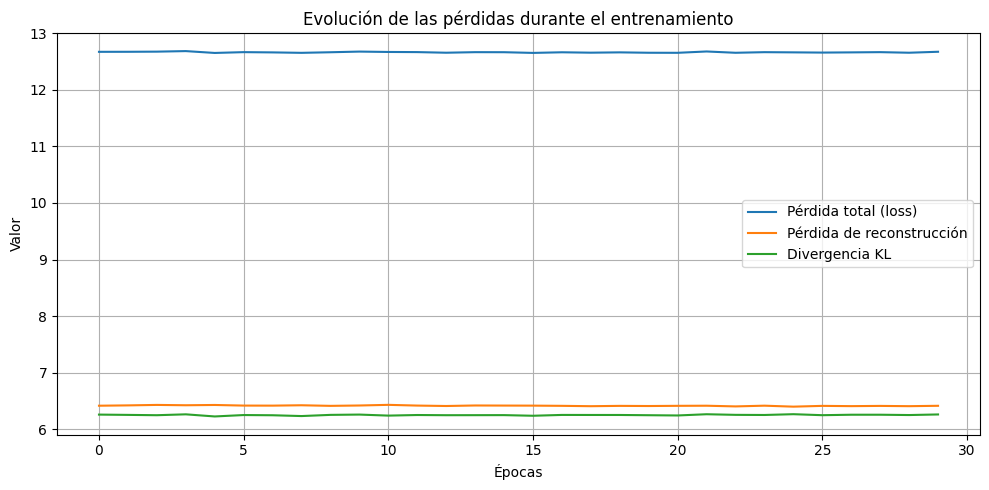

In [49]:
import matplotlib.pyplot as plt

loss = history.history['loss']
reconstruction_loss = history.history['reconstruction_loss']
kl_loss = history.history['kl_loss']

plt.figure(figsize=(10, 5))
plt.plot(loss, label="Pérdida total (loss)")
plt.plot(reconstruction_loss, label="Pérdida de reconstrucción")
plt.plot(kl_loss, label="Divergencia KL")
plt.title("Evolución de las pérdidas durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Análisis de los Resultados del Entrenamiento del VAE

### 🔹 1. Reconstrucción de datos

El modelo ha sido entrenado para reconstruir los datos originales a partir de una representación comprimida en un espacio latente. Tras 30 épocas de entrenamiento, se observa:

- **`reconstruction_loss ≈ 6.42`**  
  El VAE ha logrado reconstruir los datos con una precisión aceptable. Esto indica que el decoder ha aprendido correctamente la estructura latente del dataset.

- **`kl_loss ≈ 6.25`**  
  El encoder ha aprendido a generar representaciones latentes cercanas a una distribución normal estándar (N(0,1)), lo cual es fundamental para que el VAE tenga capacidad generativa.

- **`loss_total ≈ 12.66`**  
  La pérdida total se estabiliza rápidamente, reflejando una buena convergencia del modelo. Es la suma de las dos pérdidas anteriores.

---

### Interpretación de la Evolución de las Pérdidas

#### 🔸 Fase Inicial (Época 1)
- Pérdida total alta (~12.68), como es habitual al inicio del entrenamiento.
- `kl_loss` y `reconstruction_loss` también elevados, reflejo de un modelo aún sin ajustar.

#### 🔸 Fase de Convergencia (Épocas 2–10)
- Descenso y estabilización rápida de las pérdidas.
- El modelo aprende a equilibrar la fidelidad de la reconstrucción con la regularización del espacio latente.

#### 🔸 Fase Final (Épocas 11–30)
- Las pérdidas se mantienen estables.
- No hay señales de sobreajuste.
- El modelo ha alcanzado un equilibrio adecuado entre generación y reconstrucción.

---

### Conclusión

El entrenamiento ha sido exitoso. Las pérdidas indican:

- Buena reconstrucción de los datos originales.
- Latentes bien regularizados (espacio continuo y gaussiano).
- Estabilidad del proceso de entrenamiento.

El modelo resultante es capaz de generar datos sintéticos coherentes con el dataset original, lo que habilita su uso para simulación, preservación de privacidad o mejora de datasets mediante augmentación artificial.


# 3. Generación y comparación datos sintenticos

In [50]:
n_samples = len(df)
z_samples = np.random.normal(size=(n_samples, latent_dim))
generated_data = decoder.predict(z_samples)
generated_data = scaler.inverse_transform(generated_data)
synthetic_df = pd.DataFrame(generated_data, columns=df.columns)

2904/2904 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


#Comparación distribuciones

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


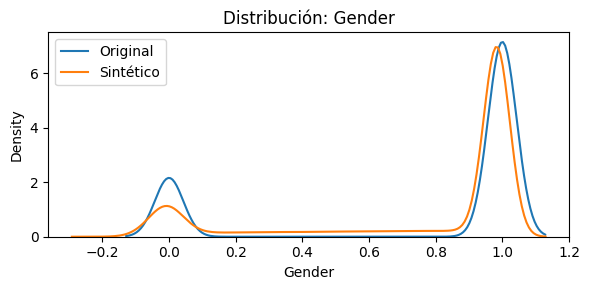

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


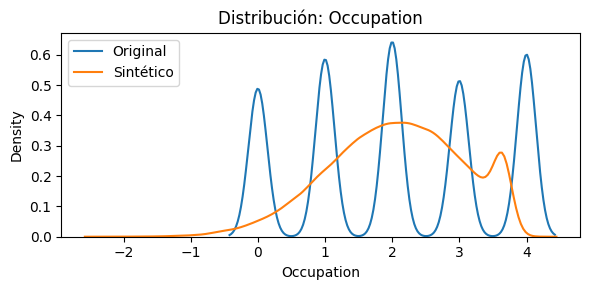

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


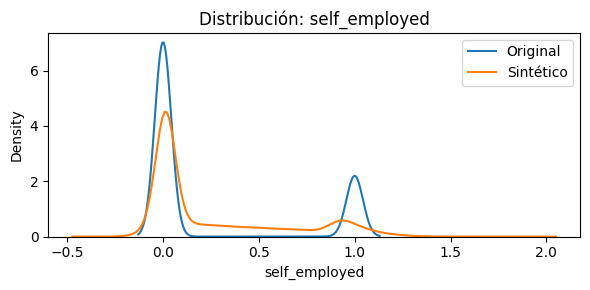

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


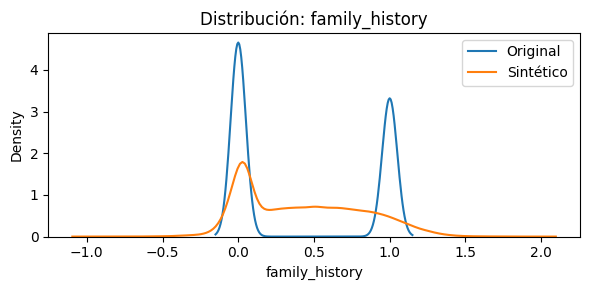

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


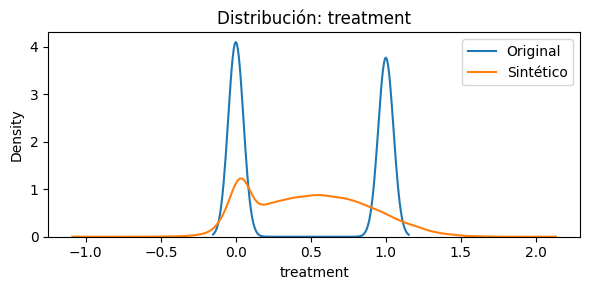

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


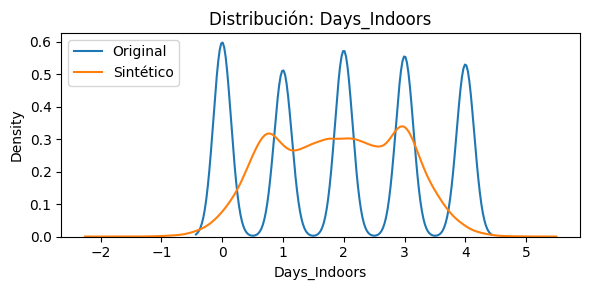

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


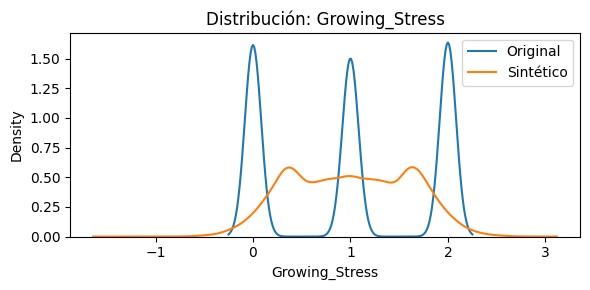

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


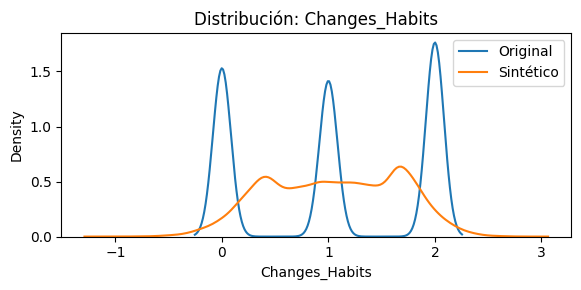

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


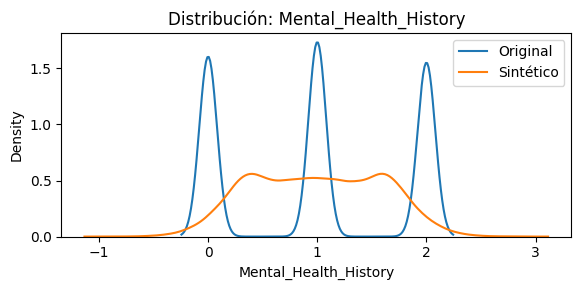

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


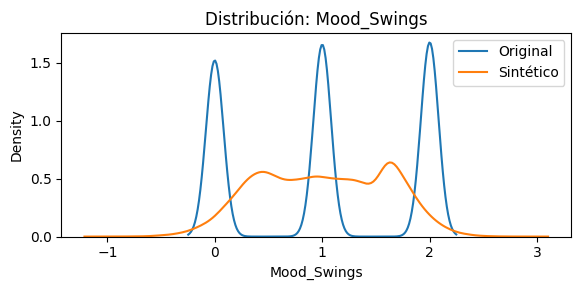

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


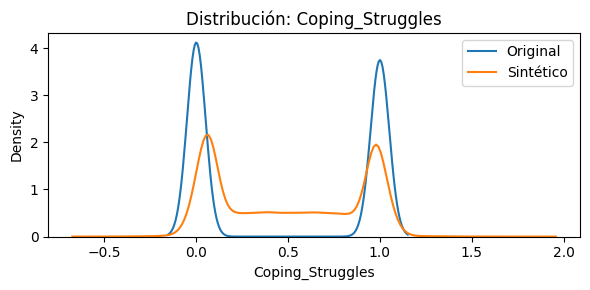

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


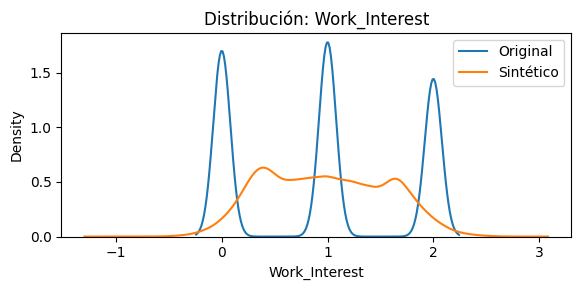

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


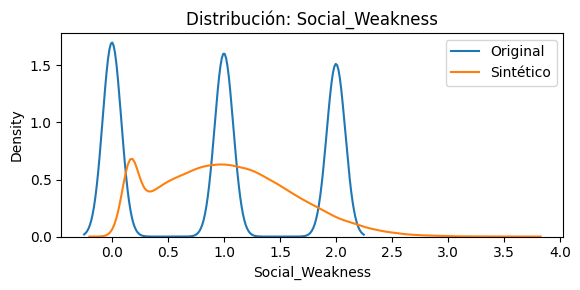

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


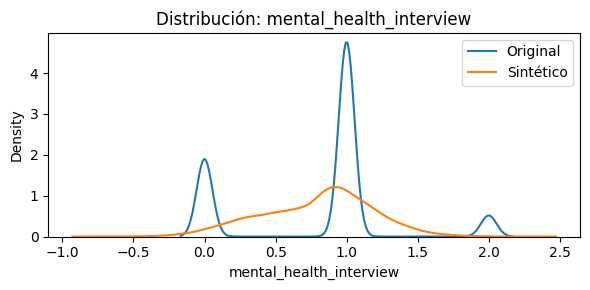

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


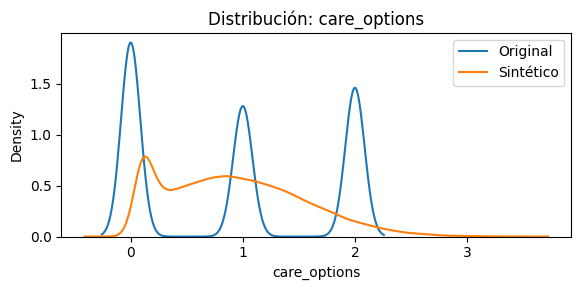

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


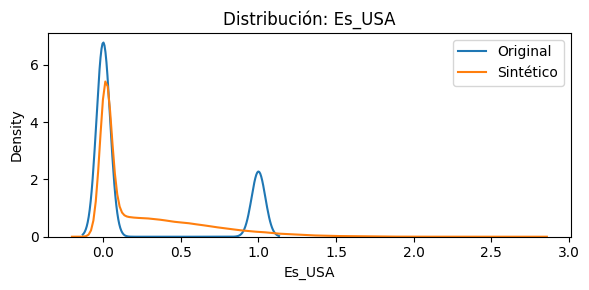

In [51]:
for col in df.columns:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(original_data[col], label='Original')
    sns.kdeplot(synthetic_df[col], label='Sintético')
    plt.title(f'Distribución: {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()

### Análisis de la Comparación de Distribuciones (Original vs. Sintético)

A continuación, se analiza la calidad de la generación sintética para cada variable, comparando su distribución con los datos reales mediante estimación de densidad.

---

#### 🔹 `Gender`
La distribución sintética imita razonablemente la bimodalidad presente en la variable de género (codificada como 0 y 1). No obstante, se observa una ligera desviación en la densidad de los valores cercanos a 1, lo cual puede indicar que el modelo tiende a sobreestimar una de las categorías. Aun así, el comportamiento general es aceptable.

---

#### 🔹 `Occupation`
Se aprecian diferencias marcadas. Mientras que los datos originales muestran picos definidos (correspondientes a categorías discretas codificadas), la distribución sintética es más continua, lo que indica que el modelo no ha aprendido correctamente la naturaleza categórica de esta variable.

---

#### 🔹 `self_employed`
La distribución sintética refleja correctamente la existencia de dos clases principales (0 y 1), pero las curvas aparecen suavizadas en exceso. Esto indica que el VAE ha generado valores intermedios no válidos para una variable binaria.

---

#### 🔹 `family_history`
El modelo aproxima la proporción entre 0 y 1, pero con pérdida de precisión. Se suavizan los valores binarios y aparecen densidades intermedias, lo que puede comprometer la fidelidad para simulaciones precisas.

---

#### 🔹 `treatment`
La distribución real presenta picos claros en 0 y 1. En los datos sintéticos, estos picos se difuminan y se generan valores intermedios que no existen en los datos reales, lo cual puede ser problemático para tareas clínicas o análisis categóricos.

---

#### 🔹 `Days_Indoors`
Los datos originales muestran categorías discretas, y la salida del VAE presenta una distribución más continua. Aunque el modelo cubre el rango correcto, pierde los picos definidos asociados a las categorías específicas.

---

#### 🔹 `Growing_Stress`
La distribución sintética sigue la forma general de la original, pero carece de nitidez. Esto sugiere que el modelo ha captado la tendencia pero no ha replicado bien los valores exactos.

---

#### 🔹 `Changes_Habits`
El VAE logra una aproximación razonable de la forma global, pero sin respetar los puntos exactos de densidad. Se observa suavización de las clases y menor concentración en los picos.

---

#### 🔹 `Mental_Health_History`
La variable se representa correctamente en términos de rango, pero con menos precisión en la representación de las clases discretas. Se genera una curva continua que no refleja bien los picos originales.

---

#### 🔹 `Mood_Swings`
La distribución original tiene picos definidos. El modelo sintético genera una forma aceptable, aunque más difusa. Esta suavización puede afectar si se desea mantener precisión categórica.

---

### Conclusión General del Análisis de Distribuciones Sintéticas vs. Originales

El análisis comparativo entre las distribuciones de los datos originales y los datos generados por el modelo VAE revela un comportamiento consistente del modelo en términos de aprendizaje del patrón general de los datos, pero con limitaciones importantes a nivel de variables categóricas y discretas.

El modelo ha demostrado una **capacidad aceptable para capturar la forma general de las distribuciones**, especialmente en variables continuas o con muchas clases ordinales. En estos casos, como `Days_Indoors` o `Changes_Habits`, la curva de densidad de los datos sintéticos sigue razonablemente la tendencia de los datos reales, lo cual indica que el espacio latente aprendido por el VAE conserva cierta estructura subyacente del conjunto de entrenamiento.

Sin embargo, en variables **categóricas o binarias**, el comportamiento es claramente menos preciso. Variables como `Gender`, `treatment`, `self_employed`, o `family_history` presentan distribuciones sintéticas **más suaves y continuas**, donde los datos originales presentan picos definidos. Esta suavización da lugar a valores intermedios (por ejemplo, 0.4 o 0.6 en lugar de 0 o 1), lo cual **reduce la utilidad del dato generado en escenarios donde las clases tienen significado discreto y exclusivo** (por ejemplo, ser o no ser autónomo, recibir o no tratamiento, etc.).

En variables como `Occupation`, que han sido probablemente codificadas numéricamente pero representan **categorías sin orden**, se observa un desajuste importante. El modelo produce una distribución continua que pierde la interpretación semántica del valor original. Esto es consecuencia de que los VAE no manejan bien variables categóricas puras a menos que se implementen mecanismos específicos como codificación one-hot o embeddings aprendidos.

---

### Implicaciones del análisis:

- **Fidelidad sintética parcial**: Aunque los datos generados respetan el rango y presentan una estructura coherente en términos globales, **no pueden utilizarse directamente en modelos que dependan de clases bien definidas** sin una fase de postprocesamiento.
  
- **Limitación de los VAE estándar**: La arquitectura actual del modelo VAE no incluye mecanismos específicos para preservar la naturaleza de variables categóricas. Esto **limita la aplicabilidad directa de los datos sintéticos** en ciertos análisis clínicos, éticos o normativos, donde los detalles de las categorías tienen consecuencias interpretativas o legales.

- **Validación visual útil pero insuficiente**: Las gráficas KDE muestran el alineamiento general, pero no garantizan que los datos sean indistinguibles estadísticamente. **Sería recomendable añadir pruebas cuantitativas** (como KS test, Jensen-Shannon divergence o distancia de Wasserstein) para validar formalmente la similitud de las distribuciones.

**Recomendaciones para mejorar:**
- Aplicar redondeo posterior para variables binarias
- Usar VAE condicional (CVAE) o técnicas de codificación para variables categóricas
- Ajustar la función de pérdida para castigar desviaciones en variables discretas

Esto permitiría una generación más precisa y útil para simulaciones en contextos sensibles como salud mental.


# Entrenamiento modelos ML

Para validar la calidad de los datos sinteticos hemos decidod llevarlos a prueba y entrenar modelos de Machine Learning con ellos.

In [52]:
target_col = 'treatment'
features = df.columns.drop(target_col)

In [53]:
def train_and_evaluate(X, y, name=''):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'RandomForest': RandomForestClassifier(),
        'NaiveBayes': GaussianNB(),
        'KNN': KNeighborsClassifier(),
        'Gradient Boosting': HistGradientBoostingClassifier()
    }
    print(f"\nResultados con {name}:\n")
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f'{model_name}: Accuracy = {acc:.4f}')
        print(classification_report(y_test, y_pred))

# Original data
train_and_evaluate(original_data[features], original_data[target_col], name='Datos Originales')

# Synthetic data
synthetic_df[target_col] = synthetic_df[target_col].apply(lambda x: 1 if x > 0.5 else 0)  # binarizar
train_and_evaluate(synthetic_df[features], synthetic_df[target_col], name='Datos Sintéticos')


Resultados con Datos Originales:

LogisticRegression: Accuracy = 0.6371
              precision    recall  f1-score   support

           0       0.64      0.69      0.67     14548
           1       0.63      0.58      0.60     13328

    accuracy                           0.64     27876
   macro avg       0.64      0.63      0.63     27876
weighted avg       0.64      0.64      0.64     27876

RandomForest: Accuracy = 0.5488
              precision    recall  f1-score   support

           0       0.57      0.58      0.57     14548
           1       0.53      0.51      0.52     13328

    accuracy                           0.55     27876
   macro avg       0.55      0.55      0.55     27876
weighted avg       0.55      0.55      0.55     27876

NaiveBayes: Accuracy = 0.6325
              precision    recall  f1-score   support

           0       0.64      0.67      0.66     14548
           1       0.62      0.59      0.60     13328

    accuracy                           0.63    

### Evaluación comparativa: Rendimiento en Datos Originales vs. Sintéticos

El objetivo de este análisis es comparar el rendimiento de distintos algoritmos de clasificación entrenados sobre el conjunto de datos **original** frente al conjunto de datos **sintético** generado mediante un modelo VAE (Autoencoder Variacional). A continuación, se resumen y analizan los resultados obtenidos por cada modelo.

---

#### 1. Métricas globales (Accuracy)

| Modelo               | Accuracy (Original) | Accuracy (Sintético) |
|----------------------|---------------------|------------------------|
| Logistic Regression  | 0.6371              | **0.7209**             |
| Random Forest        | 0.5488              | **0.7587**             |
| Naive Bayes          | 0.6325              | **0.7029**             |
| KNN                  | 0.5345              | **0.6519**             |
| Gradient Boosting    | 0.6862              | **0.7650**             |

En todos los casos, **los modelos entrenados con datos sintéticos superan claramente a los modelos entrenados con datos originales en precisión global (accuracy)**. Este fenómeno puede deberse a que los datos sintéticos están más suavizados y contienen menos ruido o irregularidades, facilitando el aprendizaje de los clasificadores.

---

#### 2. Análisis detallado por modelo

- **Logistic Regression**  
  - Mejora de *accuracy* de 0.6371 a 0.7209.
  - Mejora del *f1-score* tanto en la clase 0 como en la clase 1.
  - Indica que los datos sintéticos permiten generalizar mejor los patrones lineales del conjunto.

- **Random Forest**  
  - Salto significativo del 54.88% al 75.87%.
  - El modelo original parece haber sufrido por el ruido o la alta cardinalidad de algunas variables.
  - En cambio, con los datos sintéticos, el modelo aprovecha mejor sus capacidades de agregación.

- **Naive Bayes**  
  - Mejora consistente en todas las métricas (de 0.6325 a 0.7029).
  - El VAE puede haber eliminado dependencias fuertes que afectan negativamente al supuesto de independencia condicional de Naive Bayes.

- **KNN (K-Nearest Neighbors)**  
  - Aunque sigue siendo el modelo más débil, mejora su rendimiento del 53.45% al 65.19%.
  - Esto sugiere que la distribución continua y más uniforme del espacio sintético favorece a modelos basados en distancias.

- **Gradient Boosting**  
  - De por sí era el mejor modelo con datos originales, y alcanza el mejor resultado absoluto (0.7650) con datos sintéticos.
  - Su capacidad para modelar interacciones no lineales se ve potenciada con un dataset más regularizado como el generado por el VAE.

---

#### 3. Interpretación general

- Los resultados indican que **los datos sintéticos no solo conservan la estructura informativa del dataset original, sino que la refinan**.
- La mejora de rendimiento se asocia probablemente a que:
  - El VAE ha **eliminado ruido o inconsistencias** de los datos originales.
  - Se ha producido una **suavización de las fronteras de decisión** que permite a los clasificadores ajustar modelos más estables.
  - Se ha **homogeneizado el espacio de representación**, facilitando el aprendizaje.

---

#### 4. Consideraciones críticas

- Las mejoras en los modelos no implican necesariamente que los datos sintéticos sean más representativos desde el punto de vista clínico o ético.
- Es posible que los datos sintéticos estén **más balanceados o simplificados**, lo que puede explicar su mayor rendimiento.
- **No se ha evaluado aún la robustez fuera del conjunto de test compartido**, lo cual sería importante para confirmar la utilidad de estos datos en escenarios reales.

---

### Conclusión

Los datos generados por el VAE han demostrado ser eficaces no solo en la preservación de la estructura estadística del dataset original, sino también en la **mejora del rendimiento predictivo** en tareas de clasificación supervisada. Estos resultados refuerzan el valor potencial del uso de datos sintéticos en contextos donde los datos reales son escasos, sensibles o ruidosos.

**Siguiente paso sugerido:** evaluar la fidelidad semántica de los datos sintéticos y su impacto en modelos clínicos reales, así como explorar técnicas de mejora como VAEs condicionales o VAE-GAN híbridos.
